# Mushroom Classification — ITEC 3040 Final Project

By Mirza, Hashmat, Taha, Divine, Maxmillian

This notebook builds a classifier to predict whether a mushroom is **edible** or **poisonous** using the UCI Mushroom dataset.  
We:
- explore the dataset (EDA),
- compare different ways to handle missing values,
- evaluate several classification models using 10-fold cross-validation, and
- export the best model as a reusable pipeline for our Streamlit app.

Missing value counts:
 class                          0
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64


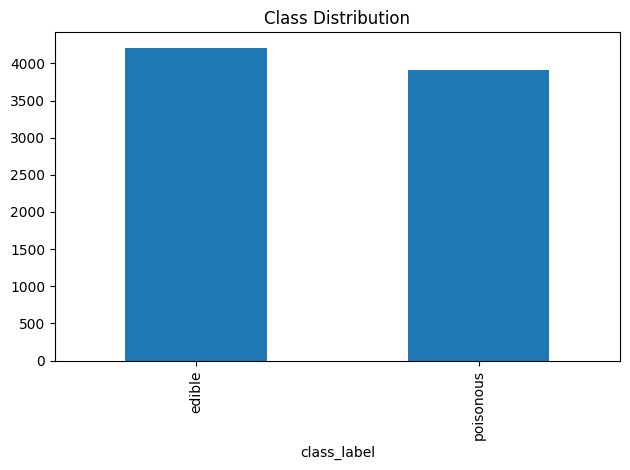

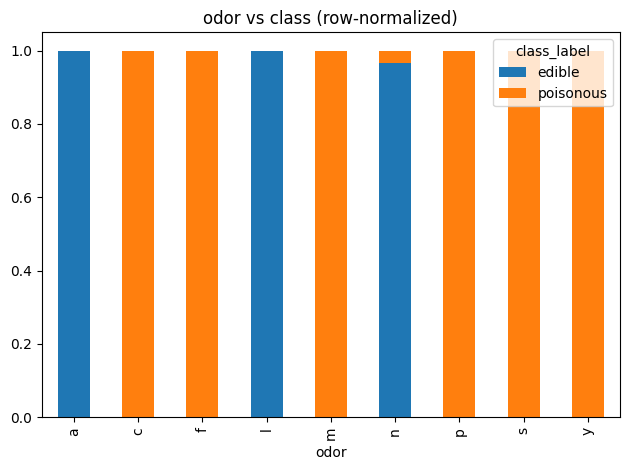

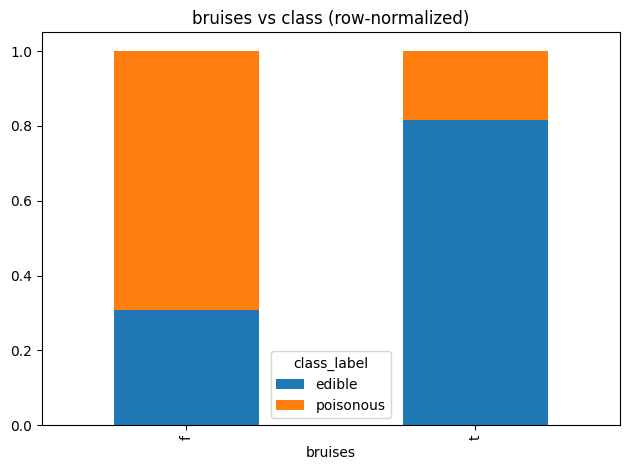

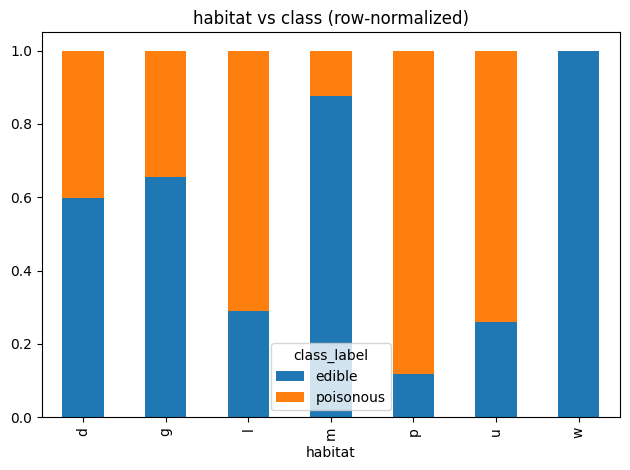

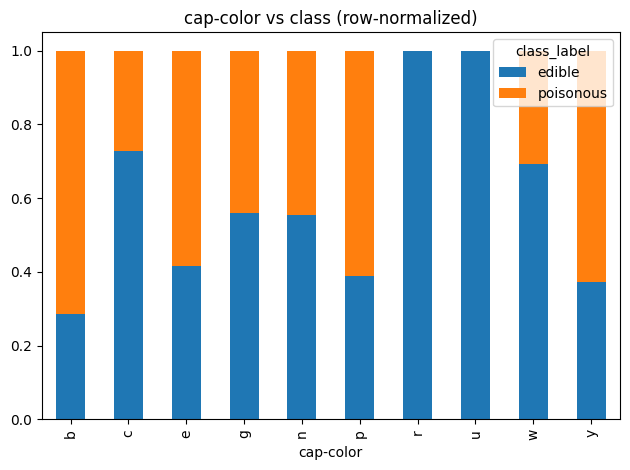

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, joblib
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

plt.style.use("default")

# Paths
ROOT = Path(".")
DATA = ROOT / "agaricus-lepiota.data"
FIG = ROOT / "figures"
FIG.mkdir(exist_ok=True)

# Column names
cols = [
    "class","cap-shape","cap-surface","cap-color","bruises","odor",
    "gill-attachment","gill-spacing","gill-size","gill-color",
    "stalk-shape","stalk-root",
    "stalk-surface-above-ring","stalk-surface-below-ring",
    "stalk-color-above-ring","stalk-color-below-ring",
    "veil-type","veil-color","ring-number","ring-type",
    "spore-print-color","population","habitat"
]

# Load dataset
df = pd.read_csv(DATA, header=None, names=cols)

# Drop veil-type if constant
if df["veil-type"].nunique() == 1:
    df = df.drop(columns=["veil-type"])

# Show missing values
print("Missing value counts:\n", (df == "?").sum())

# Prepare for plotting
df_plot = df.copy()
df_plot["class_label"] = df_plot["class"].replace({"e":"edible","p":"poisonous"})

# Class distribution plot
df_plot["class_label"].value_counts().plot(kind="bar")
plt.title("Class Distribution")
plt.tight_layout()
plt.savefig(FIG/"class_distribution.png")
plt.show()

# Feature EDA plots
for col in ["odor","bruises","habitat","cap-color"]:
    grouped = df_plot.groupby([col,"class_label"]).size().unstack(fill_value=0)
    norm = grouped.div(grouped.sum(axis=1), axis=0)
    norm.plot(kind="bar", stacked=True)
    plt.title(f"{col} vs class (row-normalized)")
    plt.tight_layout()
    plt.savefig(FIG/f"{col}_vs_class.png")
    plt.show()


In [15]:
# Target + feature matrix
X_full = df.drop(columns=["class"]).astype(str)
y = (df["class"] == "p").astype(int)

# Missing value handler
def impute_mode(series):
    non = [v for v in series.values if v != "?"]
    mode = pd.Series(non).mode().iloc[0]
    return series.replace("?", mode)

# S1 and S2
X_s1 = X_full.copy()
X_s2 = X_full.copy()
X_s2["stalk-root"] = impute_mode(X_s2["stalk-root"])

# Encoders
ct1 = ColumnTransformer([("oh", OneHotEncoder(handle_unknown="ignore"), X_s1.columns)])
ct2 = ColumnTransformer([("oh", OneHotEncoder(handle_unknown="ignore"), X_s2.columns)])
ord_enc = ColumnTransformer([("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), X_s1.columns)])

# Models
models = {
    "KNN(k=5)": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(random_state=0),
    "CategoricalNB": CategoricalNB(),
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

def evaluate(Xdata, transformer):
    rows = []
    for name, clf in models.items():
        if name == "CategoricalNB":
            pipe = Pipeline([("enc", ord_enc), ("clf", clf)])
        else:
            pipe = Pipeline([("enc", transformer), ("clf", clf)])
        scores = cross_validate(pipe, Xdata, y, cv=cv, scoring="accuracy")
        rows.append((name, scores["test_score"].mean(), scores["test_score"].std()))
    return pd.DataFrame(rows, columns=["Model","Mean Acc","Std"])

# Evaluation tables
tbl_s1 = evaluate(X_s1, ct1).assign(Strategy="S1")
tbl_s2 = evaluate(X_s2, ct2).assign(Strategy="S2")

summary = pd.concat([tbl_s1, tbl_s2]).sort_values("Mean Acc", ascending=False)
display(summary)

# Pick best row
best = summary.iloc[0]
best_model = models[best["Model"]]
best_strategy = best["Strategy"]

print("Best model:", best["Model"], " | Strategy:", best_strategy)

# Select data & encoder
if best_strategy == "S1":
    X_use, enc_use = X_s1, ct1
else:
    X_use, enc_use = X_s2, ct2

# Final pipeline
pipe_final = Pipeline([
    ("enc", ord_enc if best["Model"]=="CategoricalNB" else enc_use),
    ("clf", best_model)
])

# Train/test split evaluation
X_train, X_test, y_train, y_test = train_test_split(X_use, y, test_size=0.2, stratify=y, random_state=0)
pipe_final.fit(X_train, y_train)
y_pred = pipe_final.predict(X_test)

print("Test accuracy:", (y_pred == y_test).mean())
print("\nClassification report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()

# Export final model
joblib.dump({
    "pipeline": pipe_final,
    "strategy": best_strategy,
    "features": list(X_use.columns)
}, "mushroom_model.joblib")

print("Model saved → mushroom_model.joblib")


,Model,Mean Acc,Std,Strategy
0,KNN(k=5),1.000000,0.000000,S1
0,KNN(k=5),1.000000,0.000000,S2
1,DecisionTree,0.999754,0.000739,S1
1,DecisionTree,0.999754,0.000739,S2
2,CategoricalNB,0.955196,0.008363,S1
2,CategoricalNB,0.955072,0.008237,S2


Best model: KNN(k=5)  | Strategy: S1


NameError: name 'train_test_split' is not defined